<a href="https://colab.research.google.com/github/heroza/Skin-Cancer-Diagnosis/blob/main/Skin_Cancer_Diagnosis_using_ISIC_2018_Dataset_Split_val.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prepare the dataset. 
Currently, we use skin cancer ISIC dataset from Kaggle https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic

Tutorial for how to load Kaggle dataset can be found in https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Library and Atribut

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import Counter
from pathlib import Path
from PIL import Image
from sklearn import preprocessing
from sklearn.metrics import precision_recall_fscore_support, balanced_accuracy_score, confusion_matrix, accuracy_score
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input, Dropout, Flatten
from tensorflow.keras.models import Model, load_model
from keras.utils.np_utils import to_categorical

!pip install imbalanced-learn
import imblearn
from imblearn.over_sampling import SMOTE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# input image size
IMAGE_W = 224
IMAGE_H = 224
IMG_SIZE = (IMAGE_W,IMAGE_H)
num_classes = 7
EPOCHS = 100
BATCH_SIZE = 64
opt_adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
opt_SGD = SGD(learning_rate=0.001)

#Data augmentation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2), 
  layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3)),
  layers.experimental.preprocessing.RandomTranslation(0.3, 0.3, fill_mode='reflect', interpolation='bilinear',)
])

#Callbacks
best_model_fpath = '/content/drive/MyDrive/PHD/Model/best_model_no.h5'
last_model_fpath = '/content/drive/MyDrive/PHD/Model/last_model_no.h5'
mc = ModelCheckpoint(best_model_fpath, monitor='val_balanced_acc', mode='max', verbose=1, save_best_only=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_balanced_acc', patience=10, verbose=1, factor=0.5, min_lr=0.00001)
early_stopping_monitor = EarlyStopping(patience=30,monitor='val_balanced_acc')


#Function Definition

In [4]:
# load train and test dataset
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims

def load_cifar10_dataset():
  from keras.datasets import cifar10
	# load dataset
  (X_train, y_train), (X_val, y_val) = cifar10.load_data()
	# one hot encode target values
  y_train = to_categorical(y_train)
  y_val = to_categorical(y_val)
  X_train = preprocess_image_input(X_train)
  X_val = preprocess_image_input(X_val)

  return X_train, y_train, X_val, y_val

def balanced_acc(y_true, y_pred):
    from keras import backend as K

    tensor1 = tf.math.argmax(y_true, axis=1)
    tensor2 = tf.math.argmax(y_pred, axis=1)

    cm = tf.math.confusion_matrix(tensor1, tensor2)
    
    diag = tf.linalg.tensor_diag_part (cm)
    tpfn = tf.cast(K.sum(cm, axis = 1), tf.float32) + K.epsilon()
    recall = tf.divide(tf.cast(diag, tf.float32),tpfn)
    balanced_acc = K.mean(recall)
    return balanced_acc

def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

def define_model_resnet():
  input_tensor = Input(shape=(IMAGE_H, IMAGE_W, 3))
  #x = UpSampling2D(size=(7,7))(input_tensor)
  #x = data_augmentation(input_tensor)
  #x = layers.Rescaling(1.0 / 255)(input_tensor)  # Rescale inputs
  x = ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False)(input_tensor, training=False)
  x = GlobalAveragePooling2D()(x)
  x = Flatten()(x)
  x = Dense(1024, activation='relu')(x)
  x = Dense(512, activation='relu')(x)
  predictions = Dense(num_classes, activation='softmax')(x)
  model = Model(inputs=input_tensor, outputs=predictions)
  model.compile(optimizer = opt_SGD , loss = "categorical_crossentropy", metrics=['accuracy', balanced_acc])
  return model

# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='test')
	plt.close()
 
# scale pixels
def norm_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

def load_isic2018_dataset(train_under_frac = 0):
  df_train = pd.read_csv('/content/drive/MyDrive/PHD/Datasets/isic2018/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv') 
  df_val = pd.read_csv('/content/drive/MyDrive/PHD/Datasets/isic2018/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv') 

  #decode one hot label
  df_train["Labels"] = (df_train.iloc[:, 1:]).idxmax(axis=1)
  df_val["Labels"] = (df_val.iloc[:, 1:]).idxmax(axis=1)

  #random undersampling for training dataset
  if train_under_frac !=0:
    df_train = df_train.drop(df_train[df_train['Labels'] == 'NV'].sample(frac=train_under_frac).index)

  #drop one-hot column
  df_train = df_train.drop(columns=['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'])
  df_val = df_val.drop(columns=['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'])

  #make filepaths of the image
  dir_train = '/content/drive/MyDrive/PHD/Datasets/isic2018/ISIC2018_Task3_Training_Input/'
  dir_val = '/content/drive/MyDrive/PHD/Datasets/isic2018/ISIC2018_Task3_Validation_Input/'
  df_train['FilePaths'] = dir_train + df_train['image'] + '.jpg'
  df_val['FilePaths'] = dir_val + df_val['image'] + '.jpg'
  
  #load image pixels to dataframe
  df_train['image_px'] = df_train['FilePaths'].map(lambda x: np.asarray(Image.open(x).resize(IMG_SIZE)))
  df_val['image_px'] = df_val['FilePaths'].map(lambda x: np.asarray(Image.open(x).resize(IMG_SIZE)))

  X_train = np.asarray(df_train['image_px'].tolist())
  X_val = np.asarray(df_val['image_px'].tolist())
  y_train = np.array(df_train['Labels'].values)
  y_val = np.array(df_val['Labels'].values)

  X_train = preprocess_image_input(X_train)
  X_val = preprocess_image_input(X_val)

  label_encoder = preprocessing.LabelEncoder()
  y_train = label_encoder.fit_transform(y_train)
  y_val = label_encoder.fit_transform(y_val)
  
  y_train = to_categorical(y_train, num_classes = num_classes)
  y_val = to_categorical(y_val, num_classes = num_classes)

  return X_train, y_train, X_val, y_val, df_train, df_val

def reset_X(df_train, df_val):
  X_train = np.asarray(df_train['image_px'].tolist())
  X_val = np.asarray(df_val['image_px'].tolist())
  X_train = preprocess_image_input(X_train)
  X_val = preprocess_image_input(X_val)
  return X_train, X_val

def SMOTE_Data(X, y, one_hot = False, k = 5):
  if one_hot:
    y = np.argmax(y, axis=1)
  sm = SMOTE(random_state=42, k_neighbors=k)
  X_resampled, y_resampled = sm.fit_resample(X.reshape((-1, IMAGE_W * IMAGE_H * 3)), y)
  X_resampled = X_resampled.reshape(-1, IMAGE_W, IMAGE_H, 3)
  if one_hot:
    y_resampled = to_categorical(y_resampled, num_classes = num_classes)
  else:
    y_resampled = y_resampled.reshape(-1,1)
  return X_resampled, y_resampled

#Load ISIC 2018 Challange Data

In [ ]:
X_train, y_train, X_val, y_val = load_isic2018_dataset(train_under_frac = 0.7)

[Text(0, 0, 'DF'),
 Text(0, 0, 'VASC'),
 Text(0, 0, 'AKIEC'),
 Text(0, 0, 'BCC'),
 Text(0, 0, 'BKL'),
 Text(0, 0, 'MEL'),
 Text(0, 0, 'NV')]

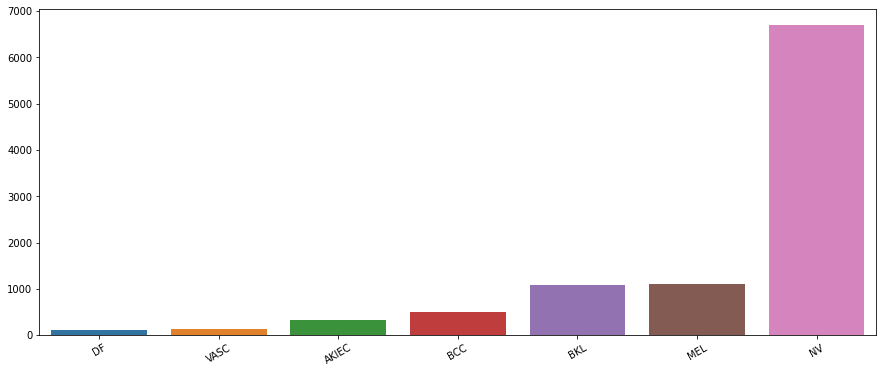

In [ ]:
# ordered count of rows per unique label
labels_count = y_train.value_counts(ascending=True)

f = plt.figure(figsize=(15, 6))
s = sns.barplot(x=labels_count.index,y=labels_count.values)
s.set_xticklabels(s.get_xticklabels(), rotation = 30)

Plot 3 images per label

In [ ]:
def plot_images_per_label(df, label, cols: int, size: tuple):
    fig, axs = plt.subplots(nrows=1, ncols=cols, figsize=size)

    cntMax = cols
    cntCur = 0
    for index, row in df.iterrows():
        if(y_train == label and cntCur < cntMax):
            axs[cntCur].imshow(plt.imread(df.FilePaths[index]))
            axs[cntCur].set_title(df.Labels[index])

            cntCur += 1
        else:
            if(cntCur >= cntMax):
                break
    
    plt.tight_layout()
    plt.show()


# unique labels
#labels = sorted(df_train['Labels'].unique())
#for label in range(7):
#    plot_images_per_label(y_train, 3, (12,9))

Drop duplicate images

In [ ]:
#df_group = pd.read_csv('/content/drive/MyDrive/PHD/Datasets/isic2018/ISIC2018_Task3_Training_LesionGroupings.csv') 
#df_train = df_train.set_index('image').join(df_group.set_index('image'))
#df_train = df_train.drop_duplicates(subset=['lesion_id'])

#SMOTE Oversampling

In [ ]:
X_train, y_train = SMOTE_Data(X_train, y_train) #beware of the actual parameter
print(X_train.shape)
print(y_train.shape)

(14077, 150528)
(14077,)


#DeepSMOTE Oversampling

In [ ]:
from numpy import moveaxis
from sklearn.neighbors import NearestNeighbors
import torch
import torch.nn as nn

max_el = np.inf

args = {}
args['dim_h'] = 64         # factor controlling size of hidden layers
args['n_channel'] = 3#1    # number of channels in the input data 
args['n_z'] = 600 #300     # number of dimensions in latent space. 
args['sigma'] = 1.0        # variance in n_z
args['lambda'] = 0.01      # hyper param for weight of discriminator loss
args['lr'] = 0.0002        # learning rate for Adam optimizer .000
args['epochs'] = 300       # how many epochs to run for
args['batch_size'] = 100   # batch size for SGD
args['save'] = True        # save weights at each epoch of training if True
args['train'] = True       # train networks if True, else load networks from
args['patience'] = 20

In [ ]:
class Encoder(nn.Module):
    def __init__(self, args):
        super(Encoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']
        
        # convolutional filters, work excellent with image data
        # [(W−K+2P)/S]+1
        self.conv = nn.Sequential(
            nn.AvgPool2d(7, stride=7),
            nn.Conv2d(self.n_channel, self.dim_h, 4, 2, 1, bias=False),# 16
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.dim_h, self.dim_h * 2, 4, 2, 1, bias=False), # 8
            nn.BatchNorm2d(self.dim_h * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.dim_h * 2, self.dim_h * 4, 4, 2, 1, bias=False),# 4
            nn.BatchNorm2d(self.dim_h * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 4, 2, 0, bias=False),#14
            nn.BatchNorm2d(self.dim_h * 8),
            nn.LeakyReLU(0.2, inplace=True))
        self.fc = nn.Linear(self.dim_h * (2 ** 3), self.n_z)

    def forward(self, x):
        x = self.conv(x)
        
        x = x.squeeze()
        x = self.fc(x)
        return x


class Decoder(nn.Module):
    def __init__(self, args):
        super(Decoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']

        # first layer is fully connected
        self.fc = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 2**3 * 7 * 7),
            nn.ReLU())

        # deconvolutional filters, essentially inverse of convolutional filters
        # H_out ​= (H_in​−1)*stride[0] − 2×padding[0] + dilation[0]×(kernel_size[0]−1) + output_padding[0] + 1
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(self.dim_h * 8, self.dim_h * 4, 4), #10
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 4, self.dim_h * 2, 4), #13
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 2, self.dim_h, 4),# 16
            nn.BatchNorm2d(self.dim_h),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h, 3, 4, 2, 1),# 32
            nn.UpsamplingBilinear2d(scale_factor=7),
            nn.Tanh())

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, self.dim_h * 2**3, 7, 7)
        x = self.deconv(x)
        return x

##############################################################################
"""set models, loss functions"""
# control which parameters are frozen / free for optimization
def free_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = True

def frozen_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = False

def biased_get_class(X, y, c):
    
    xbeg = X[y == c]
    ybeg = y[y == c]
    
    return xbeg, ybeg
    #return xclass, yclass

def G_SM(X, y,n_to_sample,cl):
    n_neigh = 5
    nn = NearestNeighbors(n_neighbors=n_neigh, n_jobs=1)
    nn.fit(X)
    dist, ind = nn.kneighbors(X)

    # generating samples
    base_indices = np.random.choice(list(range(len(X))),n_to_sample)
    neighbor_indices = np.random.choice(list(range(1, n_neigh)),n_to_sample)

    X_base = X[base_indices]
    X_neighbor = X[ind[base_indices, neighbor_indices]]

    samples = X_base + np.multiply(np.random.rand(n_to_sample,1),
            X_neighbor - X_base)

    #use 10 as label because 0 to 9 real classes and 1 fake/smoted = 10
    return samples, [cl]*n_to_sample

def DeepSMOTE_train(X_train, y_train, one_hot = False):
  from torch.utils.data import TensorDataset
  import os

  max_el = np.max(X_train)
  X_train = X_train / max_el
  X_train = moveaxis(X_train, 3, 1)
  if one_hot:
    y_train = np.argmax(y_train, axis=1)
  #X_train = X_train.astype('float32') / 255.
  
  batch_size = args['batch_size']
  patience = args['patience']
  encoder = Encoder(args)
  decoder = Decoder(args)

  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  print(device)
  decoder = decoder.to(device)
  encoder = encoder.to(device)

  train_on_gpu = torch.cuda.is_available()

  #decoder loss function
  criterion = nn.MSELoss()
  criterion = criterion.to(device)

  num_workers = 0

  #torch.Tensor returns float so if want long then use torch.tensor
  tensor_x = torch.from_numpy(X_train.copy())#torch.Tensor(X_train)
  tensor_y = torch.tensor(y_train,dtype=torch.long)
  mnist_bal = TensorDataset(tensor_x,tensor_y) 
  train_loader = torch.utils.data.DataLoader(mnist_bal, 
      batch_size=batch_size,shuffle=True,num_workers=num_workers)

  best_loss = np.inf

  enc_optim = torch.optim.Adam(encoder.parameters(), lr = args['lr'])
  dec_optim = torch.optim.Adam(decoder.parameters(), lr = args['lr'])

  for epoch in range(args['epochs']):
      train_loss = 0.0
      tmse_loss = 0.0
      tdiscr_loss = 0.0
      # train for one epoch -- set nets to train mode
      encoder.train()
      decoder.train()
  
      for images,labs in train_loader:
      
          # zero gradients for each batch
          encoder.zero_grad()
          decoder.zero_grad()
          images, labs = images.to(device), labs.to(device)
          labsn = labs.detach().cpu().numpy()
#            print('images shape', images.shape)
          # run images
          z_hat = encoder(images)
#            print('images shape after encoding', z_hat.shape)
      
          x_hat = decoder(z_hat) #decoder outputs tanh
#            print('images shape after decoding', x_hat.shape)
          mse = criterion(x_hat,images)
                  
          resx = []
          resy = []
      
          tc = np.random.choice(num_classes,1)
          #tc = 9
          xbeg = X_train[y_train == tc]
          ybeg = y_train[y_train == tc] 
          xlen = len(xbeg)
          nsamp = min(xlen, 100)
          ind = np.random.choice(list(range(len(xbeg))),nsamp,replace=False)
          xclass = xbeg[ind]
          yclass = ybeg[ind]
      
          xclen = len(xclass)
          xcminus = np.arange(1,xclen)
          
          xcplus = np.append(xcminus,0)
          xcnew = (xclass[[xcplus],:])
          xcnew = xcnew.reshape(xcnew.shape[1],xcnew.shape[2],xcnew.shape[3],xcnew.shape[4])
      
          xcnew = torch.Tensor(xcnew)
          xcnew = xcnew.to(device)
      
          #encode xclass to feature space
          xclass = torch.Tensor(xclass)
          xclass = xclass.to(device)
          xclass = encoder(xclass)
      
          xclass = xclass.detach().cpu().numpy()
      
          xc_enc = (xclass[[xcplus],:])
          xc_enc = np.squeeze(xc_enc)
      
          xc_enc = torch.Tensor(xc_enc)
          xc_enc = xc_enc.to(device)
          
          ximg = decoder(xc_enc)
          
          mse2 = criterion(ximg,xcnew)
      
          comb_loss = mse2 + mse
          comb_loss.backward()
      
          enc_optim.step()
          dec_optim.step()
      
          train_loss += comb_loss.item()*images.size(0)
          tmse_loss += mse.item()*images.size(0)
          tdiscr_loss += mse2.item()*images.size(0)

      train_loss = train_loss/len(train_loader)
      tmse_loss = tmse_loss/len(train_loader)
      tdiscr_loss = tdiscr_loss/len(train_loader)
      print('Epoch: {} \tTrain Loss: {:.6f} \tmse loss: {:.6f} \tmse2 loss: {:.6f}'.format(epoch,
              train_loss,tmse_loss,tdiscr_loss))
      
  
  
      #store the best encoder and decoder models
      #here, /crs5 is a reference to 5 way cross validation, but is not
      #necessary for illustration purposes
      if train_loss < best_loss:
          print('Saving..')
          patience = args['patience']
          path_enc = '/content/drive/MyDrive/PHD/Model/DeepSMOTE/32/bst_enc.pth'
          path_dec = '/content/drive/MyDrive/PHD/Model/DeepSMOTE/32/bst_dec.pth'
        
          torch.save(encoder.state_dict(), path_enc)
          torch.save(decoder.state_dict(), path_dec)
  
          best_loss = train_loss
      else:
          patience = patience - 1

      if patience == 0:
          print('Out of patience. \n')
          break

def DeepSMOTE_Data(X_train, y_train, one_hot = False):
  batch_size = args['batch_size']
  max_el = np.max(X_train)
  X_train = X_train / max_el
  X_train = moveaxis(X_train, 3, 1)
  if one_hot:
    y_train = np.argmax(y_train, axis=1)
  #Generate artificial images
  import torch
  np.printoptions(precision=5,suppress=True)

  #path on the computer where the models are stored
  modpth = '/content/drive/MyDrive/PHD/Model/DeepSMOTE/32/'

  path_enc = modpth + '/bst_enc.pth'
  path_dec = modpth + '/bst_dec.pth'
  
  train_on_gpu = torch.cuda.is_available()
  device = 'cuda' if torch.cuda.is_available() else 'cpu'

  encoder = Encoder(args)
  encoder.load_state_dict(torch.load(path_enc), strict=False)
  encoder = encoder.to(device)

  decoder = Decoder(args)
  decoder.load_state_dict(torch.load(path_dec), strict=False)
  decoder = decoder.to(device)

  encoder.eval()
  decoder.eval()

  resx = []
  resy = []
  
  counter = Counter(y_train)
  counter = sorted(counter.items())
  counter = [value for _, value in counter]

  for i in range(num_classes):
      torch.cuda.empty_cache()

      xclass, yclass = biased_get_class(X_train, y_train, i)
      #encode xclass to feature space
      xclass = torch.Tensor(xclass)
      xclass = xclass.to(device)
      xclass = encoder(xclass)
          
      xclass = xclass.detach().cpu().numpy()
      n = np.max(counter) - counter[i]
      if n == 0:
        continue
#        resx2 = []
#        resy2 = []
#        for j in range(batch_size, n+batch_size+1, batch_size):
#          if j <= n:
#            batch_size_max = batch_size
#          elif n % batch_size != 0:
#            batch_size_max = n%batch_size
#          else:
#            break
#          xsamp, ysamp = G_SM(xclass,yclass,batch_size_max,i)
      xsamp, ysamp = G_SM(xclass,yclass,n,i)
      ysamp = np.array(ysamp)
  
      """to generate samples for resnet"""   
      xsamp = torch.Tensor(xsamp)
      xsamp = xsamp.to(device)
      ximg = decoder(xsamp)

      ximn = ximg.detach().cpu().numpy()
#        resx2.append(ximn)
#        resy2.append(ysamp)
#        
#        resx2 = np.vstack(resx2)
#        resy2 = np.hstack(resy2)
      resx.append(ximn)
      resy.append(ysamp)
  
  resx1 = np.vstack(resx)
  resy1 = np.hstack(resy)
  resx1 = resx1.reshape(resx1.shape[0],-1)
  X_train = X_train.reshape(X_train.shape[0],-1)
  X_train = np.vstack((resx1,X_train))
  y_train = np.hstack((resy1,y_train))
  y_train = to_categorical(y_train)
  X_train = X_train.reshape(-1, 3, IMAGE_W, IMAGE_H)
  X_train = moveaxis(X_train, 1, 3)
  X_train = X_train * max_el
  return X_train, y_train

#Split dataset to train and val

In [8]:
# stratified train and rem (20%) datasets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=1)

print('Train Data: ', X_train.shape)
print('Remaining Data: ', X_val.shape)

Train Data:  (4256, 224, 224, 3)
Remaining Data:  (1065, 224, 224, 3)


In [ ]:
# stratified val and test (50%) 
from sklearn.model_selection import train_test_split
X_test, X_val, y_test, y_val = train_test_split(X_rem, y_rem, test_size=0.5, stratify=y_rem, random_state=1)

print('Test Data: ', X_test.shape)
print('Val Data: ', X_val.shape)

Test Data:  (416, 32, 32, 3)
Val Data:  (416, 32, 32, 3)


In [ ]:
#optional
# stratified train and test (10%) datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=1)

print('Train Data: ', X_train.shape)
print('Test Data: ', X_test.shape)

Train Data:  (2015, 32, 32, 3)
Test Data:  (224, 32, 32, 3)


In [ ]:
#optional
# stratified train and val (10%) datasets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y, random_state=1)

print('Train Data: ', X_train.shape)
print('Val Data: ', X_val.shape)

Train Data:  (3369, 32, 32, 3)
Val Data:  (375, 32, 32, 3)


Create and compile the model

In [ ]:
print(X_train)

In [ ]:
#Data Augmentation
dataaugment = ImageDataGenerator(
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        shear_range = 10) 

dataaugment.fit(X_train)

# Main

In [ ]:
X_train, y_train, X_val, y_val = load_cifar10_dataset()

In [5]:
#load data
X_train, y_train, X_val, y_val, df_train, df_val = load_isic2018_dataset(train_under_frac = 0.7)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(5321, 224, 224, 3)
(5321, 7)
(193, 224, 224, 3)
(193, 7)


In [ ]:
X_train, y_train = SMOTE_Data(X_train, y_train, True, 3)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print('Counter train data: ', Counter(np.argmax(y_train, axis=1)))
print('Counter val data: ', Counter(np.argmax(y_val, axis=1)))

In [ ]:
X_train, X_val= reset_X(df_train, df_val)

In [ ]:
#USe TF.data
training_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validation_data = tf.data.Dataset.from_tensor_slices((X_val, y_val))

autotune = tf.data.AUTOTUNE
train_data_batches = training_data.shuffle(buffer_size=40000).batch(BATCH_SIZE).prefetch(buffer_size=autotune)
valid_data_batches = validation_data.shuffle(buffer_size=10000).batch(BATCH_SIZE).prefetch(buffer_size=autotune)

In [28]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print('Counter train data: ', Counter(np.argmax(y_train, axis=1)))
print('Counter val data: ', Counter(np.argmax(y_val, axis=1)))

(4256, 224, 224, 3)
(4256, 7)
(1065, 224, 224, 3)
(1065, 7)
Counter train data:  Counter({5: 1608, 4: 890, 2: 879, 1: 411, 0: 262, 6: 114, 3: 92})
Counter val data:  Counter({5: 403, 4: 223, 2: 220, 1: 103, 0: 65, 6: 28, 3: 23})


In [10]:
# define model
model = define_model_resnet()
hst = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val), verbose=1,
                    steps_per_epoch=X_train.shape[0] // BATCH_SIZE, 
                    callbacks=[learning_rate_reduction,early_stopping_monitor, mc])
# learning curves
summarize_diagnostics(hst)

94781440/94765736 [==============================] - 1s 0us/step
Epoch 1/100
66/66 [==============================] - ETA: 0s - loss: 1.3645 - accuracy: 0.4813 - balanced_acc: 0.2737
Epoch 1: val_balanced_acc improved from -inf to 0.34037, saving model to /content/drive/MyDrive/PHD/Model/best_model_no.h5
66/66 [==============================] - 46s 427ms/step - loss: 1.3645 - accuracy: 0.4813 - balanced_acc: 0.2737 - val_loss: 1.1194 - val_accuracy: 0.5596 - val_balanced_acc: 0.3404 - lr: 0.0010
Epoch 2/100
66/66 [==============================] - ETA: 0s - loss: 1.0429 - accuracy: 0.5940 - balanced_acc: 0.4073
Epoch 2: val_balanced_acc improved from 0.34037 to 0.44413, saving model to /content/drive/MyDrive/PHD/Model/best_model_no.h5
66/66 [==============================] - 26s 391ms/step - loss: 1.0429 - accuracy: 0.5940 - balanced_acc: 0.4073 - val_loss: 1.0048 - val_accuracy: 0.6047 - val_balanced_acc: 0.4441 - lr: 0.0010
Epoch 3/100
66/66 [==============================] - ETA: 0s

In [ ]:
#Training
#hst = model.fit(train_data_batches,
#                    epochs = EPOCHS, validation_data = valid_data_batches,      
                    #steps_per_epoch=X_train.shape[0] // BATCH_SIZE, 
#                    callbacks=[learning_rate_reduction,early_stopping_monitor, mc])


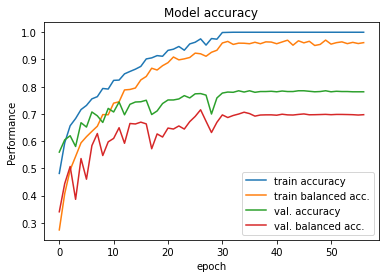

In [11]:
# summarize history for accuracy
plt.plot(hst.history['accuracy'])
plt.plot(hst.history['balanced_acc'])
plt.plot(hst.history['val_accuracy'])
plt.plot(hst.history['val_balanced_acc'])
plt.title('Model accuracy')
plt.ylabel('Performance')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'train balanced acc.', 'val. accuracy', 'val. balanced acc.'], loc='lower right')
plt.show()

#Fine Tune

In [ ]:
limit = 171
for layer in model.layers[:limit]:
   layer.trainable = False
for layer in model.layers[limit:]:
   layer.trainable = True

optimizer_SGD = SGD(learning_rate=0.0001, momentum=0.9)
model.compile(optimizer = optimizer_SGD , loss = "categorical_crossentropy", metrics=['accuracy', balanced_acc])
hst2 = model.fit(train_data_batches,
                    epochs = EPOCHS, validation_data = valid_data_batches,
                    callbacks=[learning_rate_reduction,early_stopping_monitor, mc])


In [ ]:
# summarize history for accuracy
plt.plot(hst2.history['balanced_acc'])
plt.plot(hst2.history['val_balanced_acc'])
plt.title('model balance_acc after tunning')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Evaluate

In [12]:
#save last model
model.save(last_model_fpath)

In [13]:
last_model = load_model(last_model_fpath, custom_objects={'balanced_acc' : balanced_acc})
y_train_pred = last_model.predict(X_train)
y_val_pred = last_model.predict(X_val)

#print('accuracy on training',accuracy_score(np.argmax(y_train, axis=1), np.argmax(y_train_pred, axis=1)))
print('accuracy on training',accuracy_score(np.argmax(y_train, axis=1), np.argmax(y_train_pred, axis=1)))
print('balanced accuracy on training',balanced_accuracy_score(np.argmax(y_train, axis=1), np.argmax(y_train_pred, axis=1)))
print('accuracy on validation',accuracy_score(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1)))
print('balanced accuracy on validation',balanced_accuracy_score(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1)))
print('Score on val data: ',precision_recall_fscore_support(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1), average='macro'))

accuracy on training 1.0
balanced accuracy on training 1.0
accuracy on validation 0.7812206572769953
balanced accuracy on validation 0.7055088657773556
Score on val data:  (0.7468333194331817, 0.7055088657773556, 0.7235311265927574, None)


In [14]:
best_model = load_model(best_model_fpath, custom_objects={'balanced_acc' : balanced_acc})
y_train_pred = best_model.predict(X_train)
y_val_pred = best_model.predict(X_val)

print('accuracy on training',accuracy_score(np.argmax(y_train, axis=1), np.argmax(y_train_pred, axis=1)))
print('balanced accuracy on training',balanced_accuracy_score(np.argmax(y_train, axis=1), np.argmax(y_train_pred, axis=1)))
print('accuracy on validation',accuracy_score(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1)))
print('balanced accuracy on validation',balanced_accuracy_score(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1)))
print('Score on val data: ',precision_recall_fscore_support(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1), average='macro'))

accuracy on training 0.9974154135338346
balanced accuracy on training 0.9979112359140486
accuracy on validation 0.7746478873239436
balanced accuracy on validation 0.7253847478493088
Score on val data:  (0.7393739449426127, 0.7253847478493088, 0.7313271807727036, None)


#Cut-off

In [15]:
df_val_pred = pd.DataFrame(y_val_pred, columns = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC'])

In [16]:
numbers = [float(x)/20 for x in range(11)]

for i in numbers:
    df_val_pred[i]= df_val_pred.MEL.map(lambda x: 1 if x > i else 0)
df_val_pred.head()

,AKIEC,BCC,BKL,DF,MEL,NV,VASC,0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5
0,0.000375,2.723620e-05,0.998427,3.008762e-04,0.000625,0.000244,1.780823e-07,1,0,0,0,0,0,0,0,0,0,0
1,0.039329,4.519087e-07,0.009708,8.283301e-01,0.005861,0.116771,3.500386e-07,1,0,0,0,0,0,0,0,0,0,0
2,0.000003,1.263549e-04,0.565666,8.585044e-07,0.220015,0.214187,2.469018e-06,1,1,1,1,1,0,0,0,0,0,0
3,0.000224,4.507595e-02,0.000097,2.229270e-05,0.053691,0.520665,3.802254e-01,1,1,0,0,0,0,0,0,0,0,0
4,0.002575,3.686495e-07,0.981849,2.585367e-05,0.013826,0.001724,5.354867e-08,1,0,0,0,0,0,0,0,0,0,0


In [17]:
y_val_true= [1 if x == 4 else 0 for x in np.argmax(y_val, axis=1)]

In [18]:
num = [0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]
cutoff_df = pd.DataFrame( columns = ['Probability','Accuracy','Sensitivity','Specificity'])
for i in num:
    cm1 = confusion_matrix(y_val_true, df_val_pred[i])
    total1=sum(sum(cm1))
    Accuracy = (cm1[0,0]+cm1[1,1])/total1
    Specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    Sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,Accuracy,Sensitivity,Specificity]

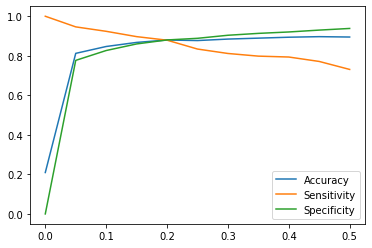

In [19]:
cutoff_df[['Accuracy','Sensitivity','Specificity']].plot()

plt.show()

#Confusion Metric on Validation Set

In [24]:
i = 0.05
cm1 = confusion_matrix(y_val_true, df_val_pred[i])
total1=sum(sum(cm1))
Accuracy = (cm1[0,0]+cm1[1,1])/total1
Specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
Sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])

In [25]:
print('Accuracy: ', Accuracy)
print('Sensitivity: ', Sensitivity)
print('Specificity: ', Specificity)

Accuracy:  0.6140845070422535
Sensitivity:  0.0
Specificity:  1.0


In [22]:
#change melanoma flag back to 4
df_val_pred[df_val_pred[i] == 1] = 4
#decode one-hot y_val_pred while use cut-off melanoma data
condition = df_val_pred[i] == 4
y_val_pred2 = np.where(condition, df_val_pred[i], np.argmax(y_val_pred, axis=1))

In [23]:
print('Accuracy: ',accuracy_score(np.argmax(y_val, axis=1), y_val_pred2))
print('Balanced accuracy: ',balanced_accuracy_score(np.argmax(y_val, axis=1), y_val_pred2))

Accuracy:  0.7305164319248826
Balanced accuracy:  0.6941582458603631


In [26]:
#Get the confusion matrix
cf_matrix = confusion_matrix(np.argmax(y_val, axis=1), y_val_pred2)
print(cf_matrix)

[[ 35   6   7   3  13   1   0]
 [  8  74   4   0  14   1   2]
 [  6  10 120   1  69  14   0]
 [  3   1   1  14   4   0   0]
 [  1   0   6   0 211   5   0]
 [  0   5   7   1  86 303   1]
 [  0   1   0   0   2   4  21]]


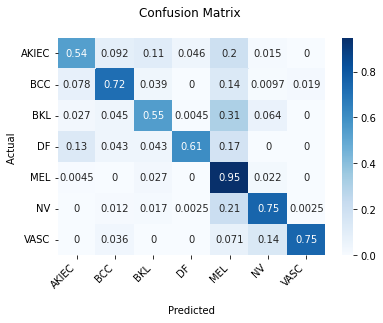

In [27]:
ax = sns.heatmap(cf_matrix / cf_matrix.sum(axis=1, keepdims=True), annot=True, 
            cmap='Blues')

ax.set_title('Confusion Matrix \n');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('Actual ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC'])
ax.yaxis.set_ticklabels(['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC'])

plt.rcParams["figure.figsize"] = (15,3)

## Display the visualization of the Confusion Matrix.
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')
plt.show()

[Text(0, 0, 'AKIEC'),
 Text(0, 0, 'BCC'),
 Text(0, 0, 'BKL'),
 Text(0, 0, 'DF'),
 Text(0, 0, 'MEL'),
 Text(0, 0, 'NV'),
 Text(0, 0, 'VASC')]

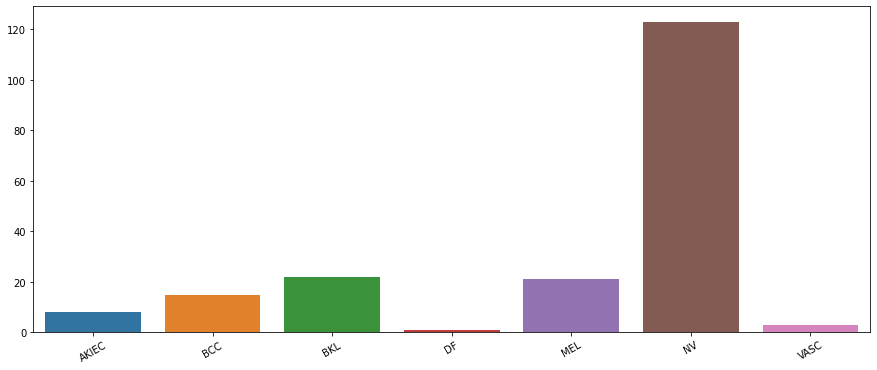

In [ ]:
# ordered count of rows per unique label
labels_count = df_val['Labels'].value_counts().sort_index()

f = plt.figure(figsize=(15, 6))
s = sns.barplot(x=labels_count.index,y=labels_count.values)
s.set_xticklabels(s.get_xticklabels(), rotation = 30)

#Testing
Result from ISIC Live
last_model: 0.506
best_model: 0.478

In [ ]:
dir_test = '/content/drive/MyDrive/PHD/Datasets/isic2018/ISIC2018_Task3_Test_Input/'
filepaths = sorted( filter( lambda x: (os.path.isfile(os.path.join(dir_test, x))) and (x.endswith('.jpg')),
                        os.listdir(dir_test) ) )

In [ ]:
df_test = pd.DataFrame(filepaths, columns =['image'])
df_test['FilePaths'] = dir_test + df_test['image']
#df_test

In [ ]:
df_test['image_px'] = df_test['FilePaths'].map(lambda x: np.asarray(Image.open(x).resize(IMG_SIZE)))

In [ ]:
X_test = np.asarray(df_test['image_px'].tolist())
print(np.array(X_test).shape)

In [ ]:
#preprocess
X_test = preprocess_image_input(X_test)

Calculate y_pred from training and testing for analysis

In [ ]:
# predicting
Y_pred2 = best_model.predict(X_test)
print("Y_pred2", Y_pred2.shape)

In [ ]:
df_pred = pd.DataFrame(Y_pred2, columns = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC'])
df_pred['image'] = df_test['FilePaths'].map(lambda x: x.replace(dir_test, '').replace('.jpg', ''))
df_pred = df_pred[['image', 'MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']]
df_pred.set_index("image", inplace = True)

In [ ]:
#update MEL data using cut-off value
df_pred.MEL[df_pred.MEL > i] = 1

In [ ]:
df_pred.loc[df_pred.MEL > i, ['NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']] = 0

In [ ]:
df_pred.to_csv('/content/drive/MyDrive/PHD/Datasets/isic2018/response_SMOTEOversampling_cut-off.csv')